<a href="https://colab.research.google.com/github/natthanich/EfficientNet_Classification_DeepTooth/blob/main/02_5_Predict_Class_Func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##เรียกใช้ CSV

In [ ]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import

In [ ]:
import os
import numpy as np
import pandas as pd
#import efficientnet.tfkeras
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# Clone Efficient

In [ ]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
/content/efficientnet_keras_transfer_learning


# Load Model

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_Func/2_5_8e-6_250_Freeze.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})


In [ ]:
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_Func/2_5_8e-6_250_Freeze.h5")
model.summary()

Model: "EffNet_Classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_no

In [ ]:
height = width = model.input_shape[1]
print(f"height: {height}, width: {width}")

height: 224, width: 224


# Data Preparation

In [ ]:
train = pd.read_csv (r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/table_cut_images/table_train_10Fold_forGender.csv')
train

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0
...,...,...,...,...,...,...,...,...,...
4184,4184,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J375.jpg,3,1
4185,4185,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J437.jpg,5,1
4186,4186,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J480.jpg,5,1
4187,4187,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J491.jpg,6,1


In [ ]:
train = train.iloc[:,1:]

In [ ]:
DATA_PATH = "/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'Normal')
print(train_dir)
test_dir = os.path.join(DATA_PATH, 'Test')
print(test_dir)

/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Normal
/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Test


In [ ]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_Name',
        y_col = 'Gender_Class',
        class_mode = 'raw',
        color_mode= 'rgb',
        target_size=(height, width), # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        batch_size=batch_size)

#label
#labels = (train_generator.class_indices)
#labels = dict((v,k) for k,v in labels.items())
#print(labels)

Found 4189 validated image filenames.


In [ ]:
test = pd.read_csv (r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/table_cut_images/table_test_forGender.csv')
test

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female
...,...,...,...,...,...,...,...,...,...
938,938,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J132.jpg,0,Female
939,939,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J145.jpg,0,Female
940,940,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J149.jpg,0,Female
941,941,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J158.jpg,0,Female


In [ ]:
test = test.iloc[:,1:]
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female
...,...,...,...,...,...,...,...,...
938,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J132.jpg,0,Female
939,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J145.jpg,0,Female
940,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J149.jpg,0,Female
941,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J158.jpg,0,Female


# Predict

In [ ]:
act_int = test['Gender_Class'].tolist() #ค่าจริง
path = test['Path_Name'].tolist() #path

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width)) #รูปทุกรูปมีขนาดไม่เท่ากันจึงตั้งไว้ว่าเวลาจะให้ model ดึงรูปมาทำนายให้ดึงรูปเข้ามาตามขนาดที่ตั้งไว้ตามพารามิตเตอร์
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)  #model ไม่สามารถทำนายรูปภาพโดยตรงได้ จึงเเปลงรูปภาพให้เป็น array เเล้วให้โมเดลทำนาย
    # Reshape
    x = x.reshape((1,) + x.shape) # เพิ่ม ไดเมนชั่นของโมเดล ให้เป็น 4 ได้ เมนชั่น โดยที่ 1, คือบอกให้โมเดลนำเข้าทีละ 1 รูปเเล้วค่อยทำนาย เเละ + ไดเมนชั่น คือ 150 ,150 ,3(สีของ RGB)
    x /= 255.
    result = model.predict([x])
    return result[0]

In [ ]:
predict_image(path[0])[0]

1/1 [==============================] - 1s 1s/step


0.60661066

In [ ]:
#Predict
pred_list = list()
prob_list = list()
img_path= path
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = predict[0]
    pred_list.append(result)
    # prob_list.append(predict[result])

1/1 [==============================] - 0s 24ms/step


In [ ]:
pred_list

[0.60661066,
 0.32183853,
 0.94866747,
 0.534681,
 0.9359004,
 0.79761994,
 0.06308318,
 0.06828038,
 0.8776237,
 0.68885404,
 0.21841326,
 0.3138795,
 0.021943377,
 0.0065778326,
 0.18759714,
 0.024568705,
 0.81740403,
 0.23183791,
 0.29794526,
 0.94090635,
 0.9283783,
 0.41058144,
 0.0045366203,
 0.030321496,
 0.72444546,
 0.21979868,
 0.0076664737,
 0.95740813,
 0.66013455,
 0.17486586,
 0.8373474,
 0.8431957,
 0.8244979,
 0.4109631,
 0.14223397,
 0.5545216,
 0.02609036,
 0.7402148,
 0.63652766,
 0.69493866,
 0.762517,
 0.2629261,
 0.17735364,
 0.4029335,
 0.9557721,
 0.7268488,
 0.9131111,
 0.12037604,
 0.27721468,
 0.54626393,
 0.3747603,
 0.7785014,
 0.7075496,
 0.9307321,
 0.7111801,
 0.16607648,
 0.48343486,
 0.5258377,
 0.57447076,
 0.1120849,
 0.38671222,
 0.24826358,
 0.58179486,
 0.62207335,
 0.6012789,
 0.83080745,
 0.7157529,
 0.06864292,
 0.09217098,
 0.9715683,
 0.99313194,
 0.025405558,
 0.16741881,
 0.11788245,
 0.10179568,
 0.15718697,
 0.04592263,
 0.74350435,
 0.73

In [ ]:
print(type(pred_list))

<class 'list'>


In [ ]:
list_pred = []
# ใช้ลูป for เพื่อแปลงค่าและเพิ่มเข้าใน NumPy array
for value in pred_list:
    if value >= 0.5:
        list_pred = np.append(list_pred, 'Male')
    else:
        list_pred = np.append(list_pred, 'Female')

# แสดงผลลัพธ์
print(list_pred)

['Male' 'Female' 'Male' 'Male' 'Male' 'Male' 'Female' 'Female' 'Male'
 'Male' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Male'
 'Female' 'Female' 'Male' 'Male' 'Female' 'Female' 'Female' 'Male'
 'Female' 'Female' 'Male' 'Male' 'Female' 'Male' 'Male' 'Male' 'Female'
 'Female' 'Male' 'Female' 'Male' 'Male' 'Male' 'Male' 'Female' 'Female'
 'Female' 'Male' 'Male' 'Male' 'Female' 'Female' 'Male' 'Female' 'Male'
 'Male' 'Male' 'Male' 'Female' 'Female' 'Male' 'Male' 'Female' 'Female'
 'Female' 'Male' 'Male' 'Male' 'Male' 'Male' 'Female' 'Female' 'Male'
 'Male' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Male'
 'Male' 'Female' 'Female' 'Male' 'Male' 'Female' 'Female' 'Female' 'Male'
 'Male' 'Male' 'Female' 'Male' 'Male' 'Male' 'Male' 'Female' 'Male'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Male' 'Female' 'Female'
 'Female' 'Male' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Male' 'Male' 'Female' 'Female' 'Female' 'Female' 'Male'
 'Female' 'Male'

In [ ]:
test['Predict_float'] = pred_list
test['Predict_str'] = list_pred
# แสดง DataFrame
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female,0.606611,Male
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female,0.321839,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female,0.948667,Male
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female,0.534681,Male
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female,0.935900,Male
...,...,...,...,...,...,...,...,...,...,...
938,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J132.jpg,0,Female,0.032696,Female
939,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J145.jpg,0,Female,0.001380,Female
940,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J149.jpg,0,Female,0.846722,Male
941,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J158.jpg,0,Female,0.012982,Female


In [ ]:
pred_str = np.array(list_pred) #แปลงเป็น array
act_str = np.array(test['Gender_Predict'].tolist())

pred_int = np.array(pred_list) #แปลงเป็น array
act_int = np.array(test['Gender_Class'].tolist()) #ค่าจริง

#confusion_matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 78.57900318133616%
              precision    recall  f1-score   support

      Female       0.79      0.78      0.79       475
        Male       0.78      0.79      0.79       468

    accuracy                           0.79       943
   macro avg       0.79      0.79      0.79       943
weighted avg       0.79      0.79      0.79       943



Text(0.5, 76.24999999999999, 'Predicted label')

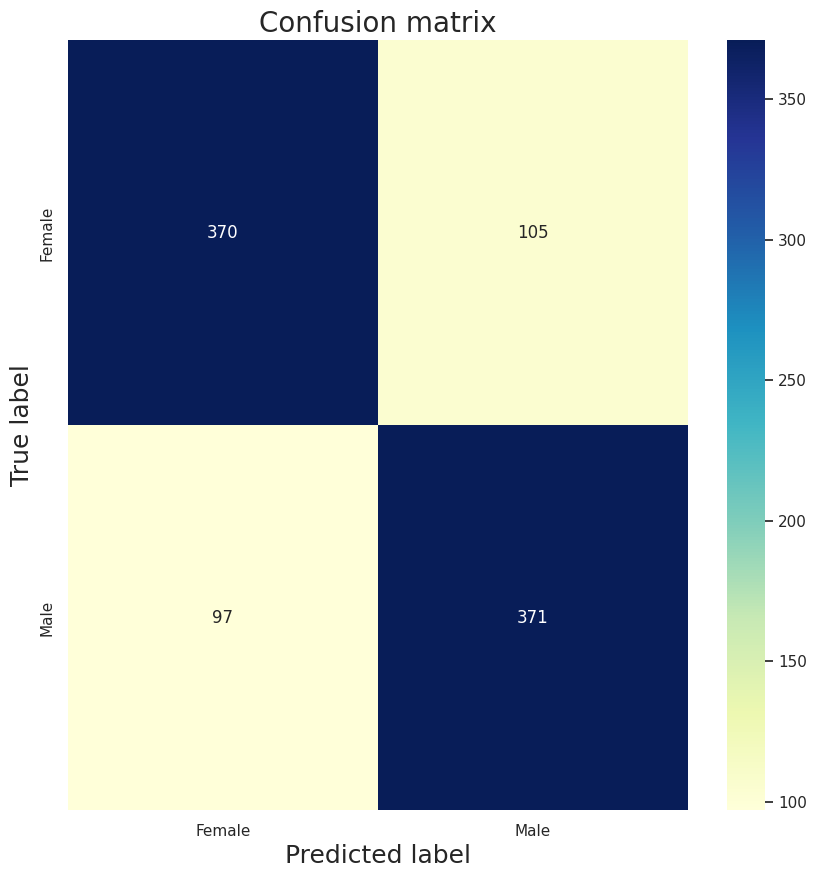

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

#MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.2663221819079254
MSE: 0.147616516459452
RMSE: 0.3842089489580533
